# 2023 CMAQ-CRACMM3 Project: PM2.5, O3, and Photochemical Age Analysis
---
    Updated paths for local analysis
    Added O3 analysis alongside PM2.5
    Data location: D:\Raw_Data\CMAQ_Model
---

In [1]:
%matplotlib inline

## Import Libraries

In [2]:
# Libraries and packages
import cmaqsatproc as csp
import pandas as pd
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import numpy as np
import glob
import netCDF4
from netCDF4 import Dataset
import PseudoNetCDF as pnc
from datetime import datetime, timedelta, date
import warnings
import scipy
from scipy.stats import bootstrap
import math
from IPython.display import display
import ast
import adjustText 
import textalloc as ta
import plotly
import plotly.express as px
import nbformat
from scipy.stats import gaussian_kde

import pyrsig
import pycno
from dateutil import rrule
import cmaps

In [3]:
# Print versions
print('csp version:    ' + csp.__version__)
print('pandas version: ' + pd.__version__)
print('xr version:     ' + xr.__version__)
print('cartopy version:' + cartopy.__version__)
print('Numpy version:  ' + np.__version__)
print('Netcdf4 version:' + netCDF4.__version__)
print('pnc version:    ' + pnc.__version__)
print('pyrsig version: ' + pyrsig.__version__)
print('pyncno version: ' + pycno.__version__)

csp version:    0.4.1
pandas version: 2.3.3
xr version:     2025.10.1
cartopy version:0.25.0
Numpy version:  2.3.4
Netcdf4 version:1.7.3
pnc version:    3.4.1
pyrsig version: 0.11.1
pyncno version: 0.3.2


In [4]:
today = str(date.today())
today = today.replace('-', '')
print('Last run on YYYYMMDD ' + str(today))

Last run on YYYYMMDD 20251118


In [5]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [6]:
# Set verbose to true to make more documentation
verbose = False

## Setup - Updated Paths for D:\Raw_Data

In [7]:
# Major file locations - UPDATED PATHS
basedir = 'D:/Raw_Data/CMAQ_Model/'
datadir = basedir  # Input data and cities.txt
outdir = basedir + 'outputs/'  # For saving CSV output and plots

# Create output directory if it doesn't exist
import os
os.makedirs(outdir, exist_ok=True)
print(f'Base directory: {basedir}')
print(f'Output directory: {outdir}')

Base directory: D:/Raw_Data/CMAQ_Model/
Output directory: D:/Raw_Data/CMAQ_Model/outputs/


In [8]:
# Proj4 info and lat/lon info
metpath = basedir + 'MOD3DATA_MET/'
m2dpath = metpath + 'METCRO2D.12US4.35L.230701'
g2dpath = metpath + 'GRIDCRO2D.12US4.35L.230701'

print(f'Meteorology path: {metpath}')
print(f'METCRO2D: {m2dpath}')
print(f'GRIDCRO2D: {g2dpath}')

Meteorology path: D:/Raw_Data/CMAQ_Model/MOD3DATA_MET/
METCRO2D: D:/Raw_Data/CMAQ_Model/MOD3DATA_MET/METCRO2D.12US4.35L.230701
GRIDCRO2D: D:/Raw_Data/CMAQ_Model/MOD3DATA_MET/GRIDCRO2D.12US4.35L.230701


In [9]:
# Display the proj4 string
f = pyrsig.open_ioapi(m2dpath)  
f.crs_proj4
cno = pycno.cno(f.crs_proj4)

In [10]:
def set_map(ax, title, colorlabel):
    """Helper function to format map plots"""
    ax.colorbar.set_label(colorlabel)
    ax.axes.set_xlabel('')
    ax.axes.set_xticklabels('')
    ax.axes.set_ylabel('')
    ax.axes.set_yticklabels('')
    plt.setp(ax.axes, **dict(title=title))
    cno.drawstates(ax=ax.axes, linewidth=0.2)

## Load CMAQ Data - CMAQv6a1 CRACMM3

In [11]:
# CMAQv6a1 CRACMM3 - Updated paths
cmaqbasedata = basedir + 'netcdffiles/COMBINE_ACONC_cmaq6acracmm3_base_2023_12US4_202306.nc'
cmaqnofiredata = basedir + 'netcdffiles/COMBINE_ACONC_cmaq6acracmm3_nofire_2023_12US4_202306.nc'

print('Loading CMAQ data...')
print(f'Base scenario: {cmaqbasedata}')
print(f'No-fire scenario: {cmaqnofiredata}')

baseconc = pyrsig.open_ioapi(cmaqbasedata)    
nofireconc = pyrsig.open_ioapi(cmaqnofiredata)

print('Data loaded successfully!')

Loading CMAQ data...
Base scenario: D:/Raw_Data/CMAQ_Model/netcdffiles/COMBINE_ACONC_cmaq6acracmm3_base_2023_12US4_202306.nc
No-fire scenario: D:/Raw_Data/CMAQ_Model/netcdffiles/COMBINE_ACONC_cmaq6acracmm3_nofire_2023_12US4_202306.nc
Data loaded successfully!


## Calculate Fire Impacts (Base - NoFire)

In [12]:
# Mean changes (2-D mean in time)
print('Calculating fire impacts...')

# PM2.5
pm25_ugm3 = baseconc['PM25_TOT'].mean(dim='TSTEP') - nofireconc['PM25_TOT'].mean(dim='TSTEP')

# Ozone - NEW! (both ppb and μg/m³)
o3_ppb = baseconc['O3'].mean(dim='TSTEP') - nofireconc['O3'].mean(dim='TSTEP')
o3_ugm3 = ((baseconc['O3'] - nofireconc['O3']) * baseconc['AIR_DENS'] * 48.00 / 28.9628).mean(dim='TSTEP')  # MW_O3 = 48.00 g/mol

# CO (both ppb and μg/m³)
co_ppb = baseconc['CO'].mean(dim='TSTEP') - nofireconc['CO'].mean(dim='TSTEP')
co_ugm3 = ((baseconc['CO'] - nofireconc['CO']) * baseconc['AIR_DENS'] * 28.01 / 28.9628).mean(dim='TSTEP')  # MW_CO = 28.01 g/mol

# Benzene and Toluene for age calculation
benzene_ppb = baseconc['BENZENE'].mean(dim='TSTEP') - nofireconc['BENZENE'].mean(dim='TSTEP')
toluene_ppb = baseconc['TOLUENE'].mean(dim='TSTEP') - nofireconc['TOLUENE'].mean(dim='TSTEP')

print('Fire impact calculations complete!')
print(f'  O3:   {o3_ppb.mean().values:.2f} ppb = {o3_ugm3.mean().values:.2f} μg/m³')
print(f'  CO:   {co_ppb.mean().values:.2f} ppb = {co_ugm3.mean().values:.2f} μg/m³')
print(f'  PM2.5: {pm25_ugm3.mean().values:.2f} μg/m³')

Calculating fire impacts...
Fire impact calculations complete!
  O3:   0.83 ppb = 1.56 μg/m³
  CO:   49.50 ppb = 54.65 μg/m³
  PM2.5: 5.18 μg/m³


## Calculate Photochemical Age

In [13]:
# Calculate photochemical age (2-D mean in time)
bentotolinitial = 2.27  # ptothna input, emission molar ratio
bentoltime = (benzene_ppb) / (toluene_ppb)
bentoltime = np.log(bentoltime / bentotolinitial) / (5.9337e-12 - 1.2196e-12) / 3600 / 24 / 1e6

print('Photochemical age calculated')
print(f'Age range: {bentoltime.min().values:.2f} to {bentoltime.max().values:.2f} days')

Photochemical age calculated
Age range: -inf to inf days


c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\xarray\computation\apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\xarray\computation\apply_ufunc.py:818: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


## PM2.5 Concentration Maps

PM2.5 base min, max: 1.14, 901.36
PM2.5 no fire min, max: 1.00, 57.60
PM2.5 delta min, max: -0.00, 898.56
PM2.5 delta % min, max: -0.11, 99.69


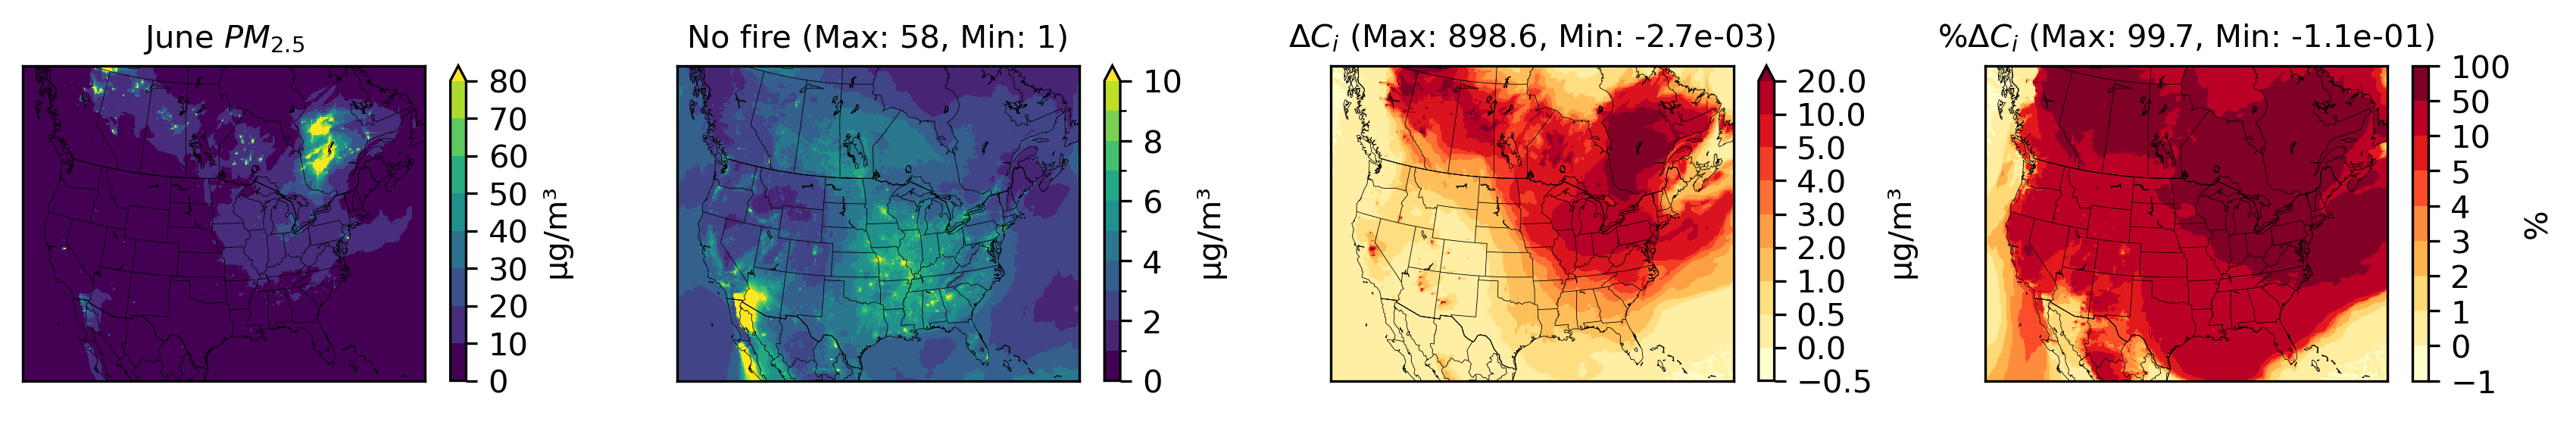

In [14]:
spc = 'PM25_TOT'
units = 'μg/m³'
printname = '$PM_{2.5}$'
colmap = plt.get_cmap('YlOrRd')
          
# Create 4-panel plot
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['figure.figsize'] = [14, 1.8]
f1, sax = plt.subplots(1, 4, dpi=300)
plt.subplots_adjust(wspace=0.3)

# Panel 0: Base simulation
plt.sca(sax[0])
conc = baseconc[spc].mean(dim='TSTEP')
print(f"PM2.5 base min, max: {conc.min().values:.2f}, {conc.max().values:.2f}")
levelsforplot = [0, 10, 20, 30, 40, 50, 60, 70, 80]
plotvar = conc.plot(cmap='viridis', levels=levelsforplot)
title = f'June {printname}'
sax[0].axes.set_xticks([])
sax[0].axes.set_yticks([])
set_map(ax=plotvar, title=title, colorlabel=units)

# Panel 1: No-fire simulation
plt.sca(sax[1])
conc = nofireconc[spc].mean(dim='TSTEP')
print(f"PM2.5 no fire min, max: {conc.min().values:.2f}, {conc.max().values:.2f}")
levelsforplot = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plotvar = conc.plot(cmap='viridis', levels=levelsforplot)
title = f'No fire (Max: {conc.max().values:.0f}, Min: {conc.min().values:.0f})'
sax[1].axes.set_xticks([])
sax[1].axes.set_yticks([])
set_map(ax=plotvar, title=title, colorlabel=units)

# Panel 2: Fire delta (absolute)
plt.sca(sax[2])
conc = pm25_ugm3
print(f"PM2.5 delta min, max: {conc.min().values:.2f}, {conc.max().values:.2f}")
levelsforplot = [-0.5, 0, 0.5, 1, 2, 3, 4, 5, 10, 20]
plotvar = conc.plot(cmap=colmap, levels=levelsforplot)
title = f'$\\Delta$$C_i$ (Max: {conc.max().values:.1f}, Min: {conc.min().values:.1e})'
sax[2].axes.set_xticks([])
sax[2].axes.set_yticks([])
set_map(ax=plotvar, title=title, colorlabel=units)

# Panel 3: Fire delta (percent)
plt.sca(sax[3])
conc = (baseconc[spc].mean(dim='TSTEP') - nofireconc[spc].mean(dim='TSTEP')) / baseconc[spc].mean(dim='TSTEP') * 100
print(f"PM2.5 delta % min, max: {conc.min().values:.2f}, {conc.max().values:.2f}")
levelsforplot = [-1, 0, 1, 2, 3, 4, 5, 10, 50, 100]
plotvar = conc.plot(cmap=colmap, levels=levelsforplot)
title = f'%$\\Delta$$C_i$ (Max: {conc.max().values:.1f}, Min: {conc.min().values:.1e})'
sax[3].axes.set_xticks([])
sax[3].axes.set_yticks([])
set_map(ax=plotvar, title=title, colorlabel='%')

plt.savefig(f'{outdir}/{today}_PM25_maps.png', dpi=300, bbox_inches='tight')
plt.show()

## O3 Concentration Maps - NEW ANALYSIS

O3 base min, max: 13.73, 53.25
O3 no fire min, max: 13.71, 53.03
O3 delta min, max: -0.91, 5.17
O3 delta % min, max: -3.25, 20.71


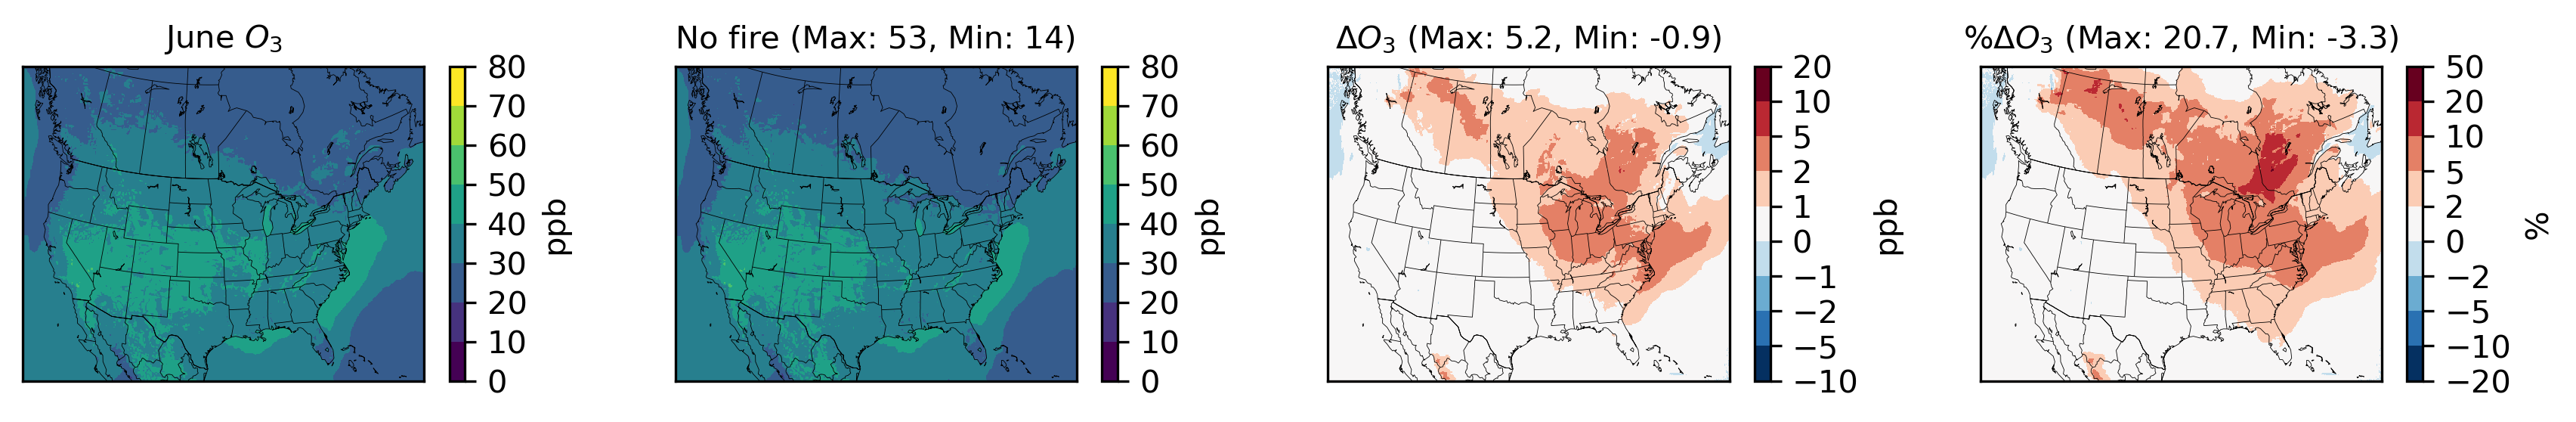

In [15]:
spc = 'O3'
units = 'ppb'
printname = '$O_3$'
colmap_o3 = plt.get_cmap('RdBu_r')  # Red-Blue reversed for O3
          
# Create 4-panel plot
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['figure.figsize'] = [14, 1.8]
f1, sax = plt.subplots(1, 4, dpi=300)
plt.subplots_adjust(wspace=0.3)

# Panel 0: Base simulation
plt.sca(sax[0])
conc = baseconc[spc].mean(dim='TSTEP')
print(f"O3 base min, max: {conc.min().values:.2f}, {conc.max().values:.2f}")
levelsforplot = [0, 10, 20, 30, 40, 50, 60, 70, 80]
plotvar = conc.plot(cmap='viridis', levels=levelsforplot)
title = f'June {printname}'
sax[0].axes.set_xticks([])
sax[0].axes.set_yticks([])
set_map(ax=plotvar, title=title, colorlabel=units)

# Panel 1: No-fire simulation
plt.sca(sax[1])
conc = nofireconc[spc].mean(dim='TSTEP')
print(f"O3 no fire min, max: {conc.min().values:.2f}, {conc.max().values:.2f}")
levelsforplot = [0, 10, 20, 30, 40, 50, 60, 70, 80]
plotvar = conc.plot(cmap='viridis', levels=levelsforplot)
title = f'No fire (Max: {conc.max().values:.0f}, Min: {conc.min().values:.0f})'
sax[1].axes.set_xticks([])
sax[1].axes.set_yticks([])
set_map(ax=plotvar, title=title, colorlabel=units)

# Panel 2: Fire delta (absolute) - Can be positive or negative for O3!
plt.sca(sax[2])
conc = o3_ppb
print(f"O3 delta min, max: {conc.min().values:.2f}, {conc.max().values:.2f}")
levelsforplot = [-10, -5, -2, -1, 0, 1, 2, 5, 10, 20]
plotvar = conc.plot(cmap=colmap_o3, levels=levelsforplot)
title = f'$\\Delta$$O_3$ (Max: {conc.max().values:.1f}, Min: {conc.min().values:.1f})'
sax[2].axes.set_xticks([])
sax[2].axes.set_yticks([])
set_map(ax=plotvar, title=title, colorlabel=units)

# Panel 3: Fire delta (percent)
plt.sca(sax[3])
conc = (baseconc[spc].mean(dim='TSTEP') - nofireconc[spc].mean(dim='TSTEP')) / nofireconc[spc].mean(dim='TSTEP') * 100
print(f"O3 delta % min, max: {conc.min().values:.2f}, {conc.max().values:.2f}")
levelsforplot = [-20, -10, -5, -2, 0, 2, 5, 10, 20, 50]
plotvar = conc.plot(cmap=colmap_o3, levels=levelsforplot)
title = f'%$\\Delta$$O_3$ (Max: {conc.max().values:.1f}, Min: {conc.min().values:.1f})'
sax[3].axes.set_xticks([])
sax[3].axes.set_yticks([])
set_map(ax=plotvar, title=title, colorlabel='%')

plt.savefig(f'{outdir}/{today}_O3_maps.png', dpi=300, bbox_inches='tight')
plt.show()

## Photochemical Age Map

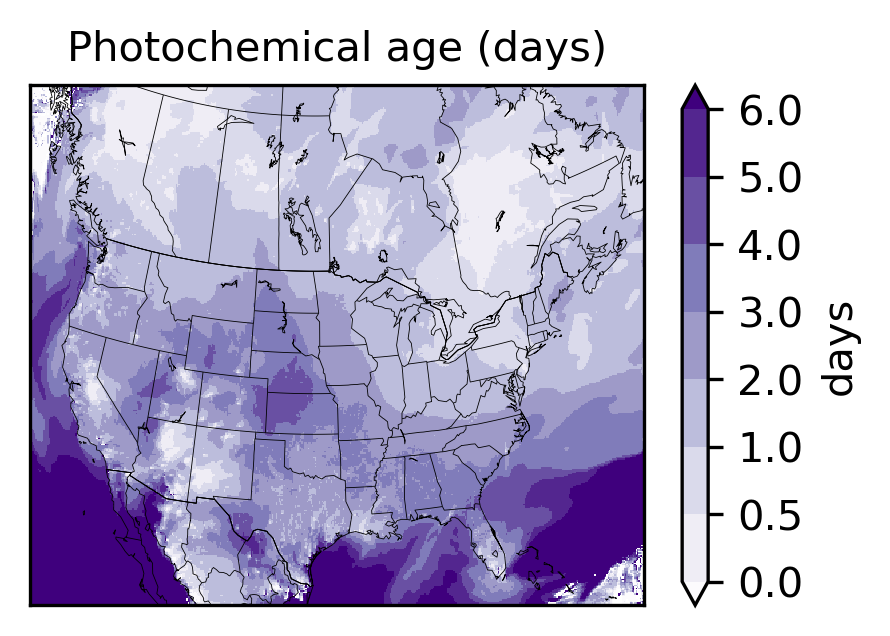

In [16]:
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['figure.figsize'] = [3.3, 2.25]
f1, sax = plt.subplots(1, 1, dpi=300)
plt.sca(sax)

conc = bentoltime
lab = 'days'
colmap = plt.get_cmap('Purples')
levelsforplot = [0, 0.5, 1, 2, 3, 4, 5, 6]
plotvar = conc.plot(cmap=colmap, levels=levelsforplot, edgecolor=None)
sax.axes.set_xticks([])
sax.axes.set_yticks([])
title = 'Photochemical age (days)'
set_map(ax=plotvar, title=title, colorlabel=lab)

plt.savefig(f'{outdir}/{today}_photochem_age_map.png', dpi=300, bbox_inches='tight')
plt.show()

## Load Cities for Time Series Analysis

In [17]:
# Load grid info
grid = pnc.pncopen(g2dpath, format='ioapi')

# Load cities
sites = pd.read_csv(datadir + 'cities.txt', header=None)
sites = sites.rename(columns={1: "lon", 2: "lat", 0: 'site'})
print('Cities loaded:')
display(sites)

Cities loaded:


,site,lon,lat
0,NYC,-74.006000,40.712800
1,Chicago,-87.629800,41.878100
2,Toronto,-79.347015,43.651070
3,Montreal,-73.561668,45.508888
4,Vancouver,-123.116226,49.246292
5,Calgary,-114.066666,51.049999
6,Ottawa,-75.695000,45.424721
7,Edmonton,-113.323975,53.631611
8,MacKenzie Co.,-118.318000,58.543000
9,Winnipeg,-97.138451,49.895077


## Prepare Data for Smoke-Masked Analysis

In [18]:
# Mask for smoke conditions
smokemask = benzene_ppb > 0.010  # 10 ppt benzene enhancement to detect fire smoke

# Create 1-D data (masked for smoke)
time_masked = bentoltime.where(smokemask, drop=True).squeeze().stack(z=('ROW', 'COL')).dropna(dim="z", how="any")
coppb_masked = co_ppb.where(smokemask, drop=True).squeeze().stack(z=('ROW', 'COL')).dropna(dim="z", how="any")
pm25ugm3_masked = pm25_ugm3.where(smokemask, drop=True).squeeze().stack(z=('ROW', 'COL')).dropna(dim="z", how="any")
o3ppb_masked = o3_ppb.where(smokemask, drop=True).squeeze().stack(z=('ROW', 'COL')).dropna(dim="z", how="any")
o3ugm3_masked = o3_ugm3.where(smokemask, drop=True).squeeze().stack(z=('ROW', 'COL')).dropna(dim="z", how="any")  # NEW!

# Mass ratios (g/g) - for comparing with PM2.5/CO
pmrelcogg_masked = (pm25_ugm3.squeeze() / co_ugm3.squeeze()).where(smokemask.squeeze(), drop=True).stack(z=('ROW', 'COL')).dropna(dim="z", how="any")
o3relcogg_masked = (o3_ugm3.squeeze() / co_ugm3.squeeze()).where(smokemask.squeeze(), drop=True).stack(z=('ROW', 'COL')).dropna(dim="z", how="any")  # NEW! (g/g)

# Molar ratio (ppb/ppb) - for reference
o3relco_ppb_masked = (o3_ppb.squeeze() / co_ppb.squeeze()).where(smokemask.squeeze(), drop=True).stack(z=('ROW', 'COL')).dropna(dim="z", how="any")

# Create DataFrame
dfplot = pd.DataFrame({
    'time': time_masked,
    'co_ppb': coppb_masked,
    'pm25': pm25ugm3_masked,
    'o3_ppb': o3ppb_masked,
    'o3_ugm3': o3ugm3_masked,
    'pmco_gg': pmrelcogg_masked,
    'o3co_gg': o3relcogg_masked,
    'o3co_ppb': o3relco_ppb_masked
})

print(f'Smoke-masked data points: {len(dfplot)}')
print('\\nData summary:')
display(dfplot.describe())

Smoke-masked data points: 89436
\nData summary:


,time,co_ppb,pm25,o3_ppb,o3_ugm3,pmco_gg,o3co_gg,o3co_ppb
count,89436.000000,89436.000000,89436.000000,89436.000000,89436.000000,89436.000000,89436.000000,89436.000000
mean,1.555811,86.906349,9.141641,1.352541,2.561338,0.083243,0.038534,0.022548
std,0.955258,129.065186,18.753525,0.771042,1.475101,0.021694,0.019389,0.011328
min,0.010265,6.276070,0.250569,-0.905527,-1.582523,0.017815,-0.026446,-0.015536
25%,0.843098,29.137976,2.314552,0.743761,1.397414,0.068979,0.026405,0.015463
50%,1.301933,57.964577,5.018579,1.253309,2.394280,0.081377,0.037136,0.021735
75%,2.095364,105.432472,9.817289,1.852469,3.514028,0.097588,0.048351,0.028308
max,4.953865,5423.542969,898.558533,5.170658,9.827055,0.198840,0.357938,0.209278


In [19]:
# Create quantile bins
qcount = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
dfplot['bins'] = pd.qcut(np.log(dfplot['time']), qcount)
dfbin = dfplot.groupby(['bins']).median().dropna()

print('Binned data created')
display(dfbin)

Binned data created


C:\Users\smtku\AppData\Local\Temp\ipykernel_45028\1043133552.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfbin = dfplot.groupby(['bins']).median().dropna()


,time,co_ppb,pm25,o3_ppb,o3_ugm3,pmco_gg,o3co_gg,o3co_ppb
bins,,,,,,,,
"(-4.58, -0.63]",0.391378,191.598633,24.780451,1.688324,3.165012,0.116718,0.014175,0.008323
"(-0.63, -0.303]",0.638219,105.551186,11.347527,1.278119,2.394829,0.102384,0.022289,0.013054
"(-0.303, -0.0688]",0.843104,89.993980,9.170990,1.598377,3.022266,0.091269,0.028756,0.016808
"(-0.0688, 0.104]",1.018567,77.337952,7.078099,1.453194,2.753469,0.085111,0.031047,0.018147
"(0.104, 0.264]",1.207209,61.264481,5.484316,1.324289,2.539341,0.081290,0.037385,0.021844
"(0.264, 0.423]",1.405359,50.210365,4.396624,1.203838,2.264072,0.078105,0.040020,0.023413
"(0.423, 0.61]",1.668162,48.342110,4.226991,1.186218,2.294585,0.070361,0.040542,0.023765
"(0.61, 0.883]",2.095390,50.630787,4.177540,1.499105,2.843481,0.068020,0.044774,0.026249
"(0.883, 1.126]",2.784947,39.000870,3.201995,1.136822,2.129144,0.073975,0.049729,0.029140


In [20]:
# Helper function for 2D histogram background
def using_hist2d(ax, x, y, bins=(50, 50)):
    # https://stackoverflow.com/a/20105673/3015186
    # Answer by askewchan
    ax.hist2d(x, y, bins, cmap=plt.cm.Blues)

## PM2.5 vs Photochemical Age

NYC 0.95158994 12.820763 NY
Chicago 1.0777879 12.526935 Ch
Toronto 0.71331304 14.536686 To
Montreal 0.7944435 10.970475 Mo
Vancouver 1.5036621 0.1754551 Va
Calgary 1.1002543 2.6199465 Ca
Ottawa 0.6478576 20.299885 Ot
Edmonton 1.3536474 4.17813 Ed
MacKenzie Co. 0.46551284 12.991386 Ma
Winnipeg 1.5178015 5.500083 Wi
Atlanta 3.0071683 2.9444122 At
NYC 0.95158994 0.08275717 NY
Chicago 1.0777879 0.08698339 Ch
Toronto 0.71331304 0.09130306 To
Montreal 0.7944435 0.08418456 Mo
Vancouver 1.5036621 0.08927531 Va
Calgary 1.1002543 0.054942653 Ca
Ottawa 0.6478576 0.09407732 Ot
Edmonton 1.3536474 0.07173466 Ed
MacKenzie Co. 0.46551284 0.10421953 Ma
Winnipeg 1.5178015 0.08080177 Wi
Atlanta 3.0071683 0.067436114 At


**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consis

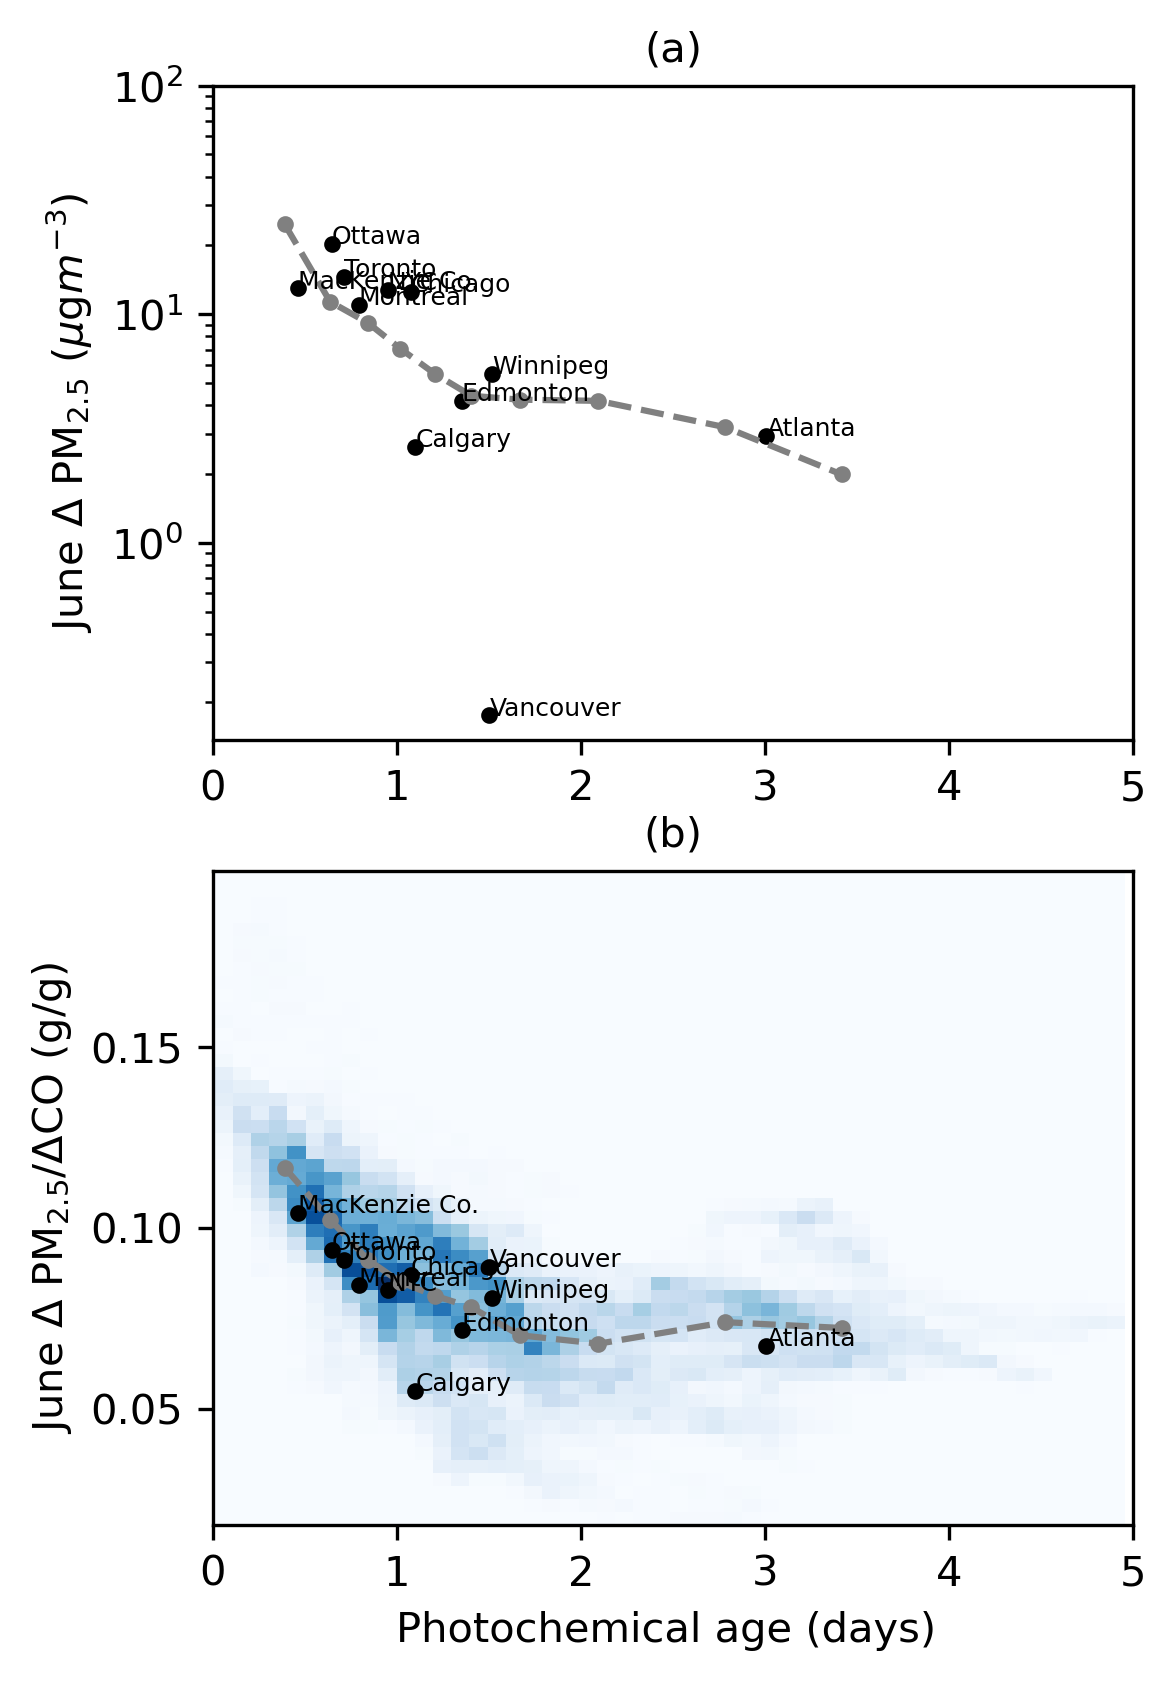

In [21]:
panelfontsize = 10
fig, rax = plt.subplots(
    2, 1, figsize=(3.3, 9.9*2/3), gridspec_kw=dict(
        wspace=0.35, left=0.06, right=0.99, top=0.95, bottom=0.223
    ), dpi=300
)

# Panel 0: PM2.5 vs age
ax = rax[0]
#using_hist2d(ax, dfplot['time'], np.log(dfplot['pm25']))  # Optional: uncomment for density background
ax.plot(dfbin['time'], dfbin['pm25'], '--', color='grey')
ax.plot(dfbin['time'], dfbin['pm25'], '.', color='grey')
ax.set(xlabel=' ', ylabel='June $\\Delta$ PM$_{2.5}$ ($\\mu$g$m^{-3}$)', yscale='log')
ax.xaxis.set_tick_params(labelsize=panelfontsize)
ax.yaxis.set_tick_params(labelsize=panelfontsize)
ax.xaxis.label.set_size(panelfontsize)
ax.yaxis.label.set_size(panelfontsize)

# Add city markers
for index, row in sites.iterrows():
    lonin = row['lon']
    latin = row['lat']
    i, j = grid.ll2ij(lonin, latin)
    yval = np.array((pm25_ugm3.squeeze())[j, i].squeeze().data, ndmin=1)[0]
    xval = np.array(bentoltime[:, j, i].squeeze().data, ndmin=1)[0]
    print(row['site'] + ' ' + str(xval) + ' ' + str(yval) + ' ' + row['site'][0:2])
    ax.text(xval, yval, row['site'], fontsize=6)
    ax.scatter(xval, yval, marker='.', color='black')

ax.set_title('(a)')
ax.set_xlim(0, 5)
ax.set_ylim(0, 100)

# Panel 1: PM2.5/CO vs age
ax = rax[1]
using_hist2d(ax, dfplot['time'], dfplot['pmco_gg'])  # 2D histogram background
ax.plot(dfbin['time'], dfbin['pmco_gg'], '--', color='grey')
ax.plot(dfbin['time'], dfbin['pmco_gg'], '.', color='grey')
ax.set(xlabel='Photochemical age (days) ', ylabel='June $\\Delta$ PM$_{2.5}$/$\\Delta$CO (g/g)')
ax.xaxis.set_tick_params(labelsize=panelfontsize)
ax.yaxis.set_tick_params(labelsize=panelfontsize)
ax.xaxis.label.set_size(panelfontsize)
ax.yaxis.label.set_size(panelfontsize)

# Add city markers
for index, row in sites.iterrows():
    lonin = row['lon']
    latin = row['lat']
    i, j = grid.ll2ij(lonin, latin)
    yval = np.array((pm25_ugm3.squeeze() / co_ugm3.squeeze())[j, i].data, ndmin=1)[0]
    xval = np.array(bentoltime[:, j, i].squeeze().data, ndmin=1)[0]
    print(row['site'] + ' ' + str(xval) + ' ' + str(yval) + ' ' + row['site'][0:2])
    ax.text(xval, yval, row['site'], fontsize=6)
    ax.scatter(xval, yval, marker='.', color='black')

ax.set_title('(b)')
ax.set_xlim(0, 5)

plt.savefig(f'{outdir}/{today}_PM25_vs_age.png', dpi=300, bbox_inches='tight')
plt.show()

# Ozone

**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consis

NYC 0.95158994 2.0163574 NY
Chicago 1.0777879 2.0357323 Ch
Toronto 0.71331304 2.260891 To
Montreal 0.7944435 1.2691269 Mo
Vancouver 1.5036621 0.046316147 Va
Calgary 1.1002543 0.7368202 Ca
Ottawa 0.6478576 1.7619324 Ot
Edmonton 1.3536474 1.0451717 Ed
MacKenzie Co. 0.46551284 1.9801579 Ma
Winnipeg 1.5178015 1.498064 Wi
Atlanta 3.0071683 1.0965233 At
NYC 0.95158994 0.025259603 NY
Chicago 1.0777879 0.02738238 Ch
Toronto 0.71331304 0.027565358 To
Montreal 0.7944435 0.018842215 Mo
Vancouver 1.5036621 0.045717966 Va
Calgary 1.1002543 0.026985288 Ca
Ottawa 0.6478576 0.015777305 Ot
Edmonton 1.3536474 0.032582223 Ed
MacKenzie Co. 0.46551284 0.029789006 Ma
Winnipeg 1.5178015 0.041586597 Wi
Atlanta 3.0071683 0.04670019 At


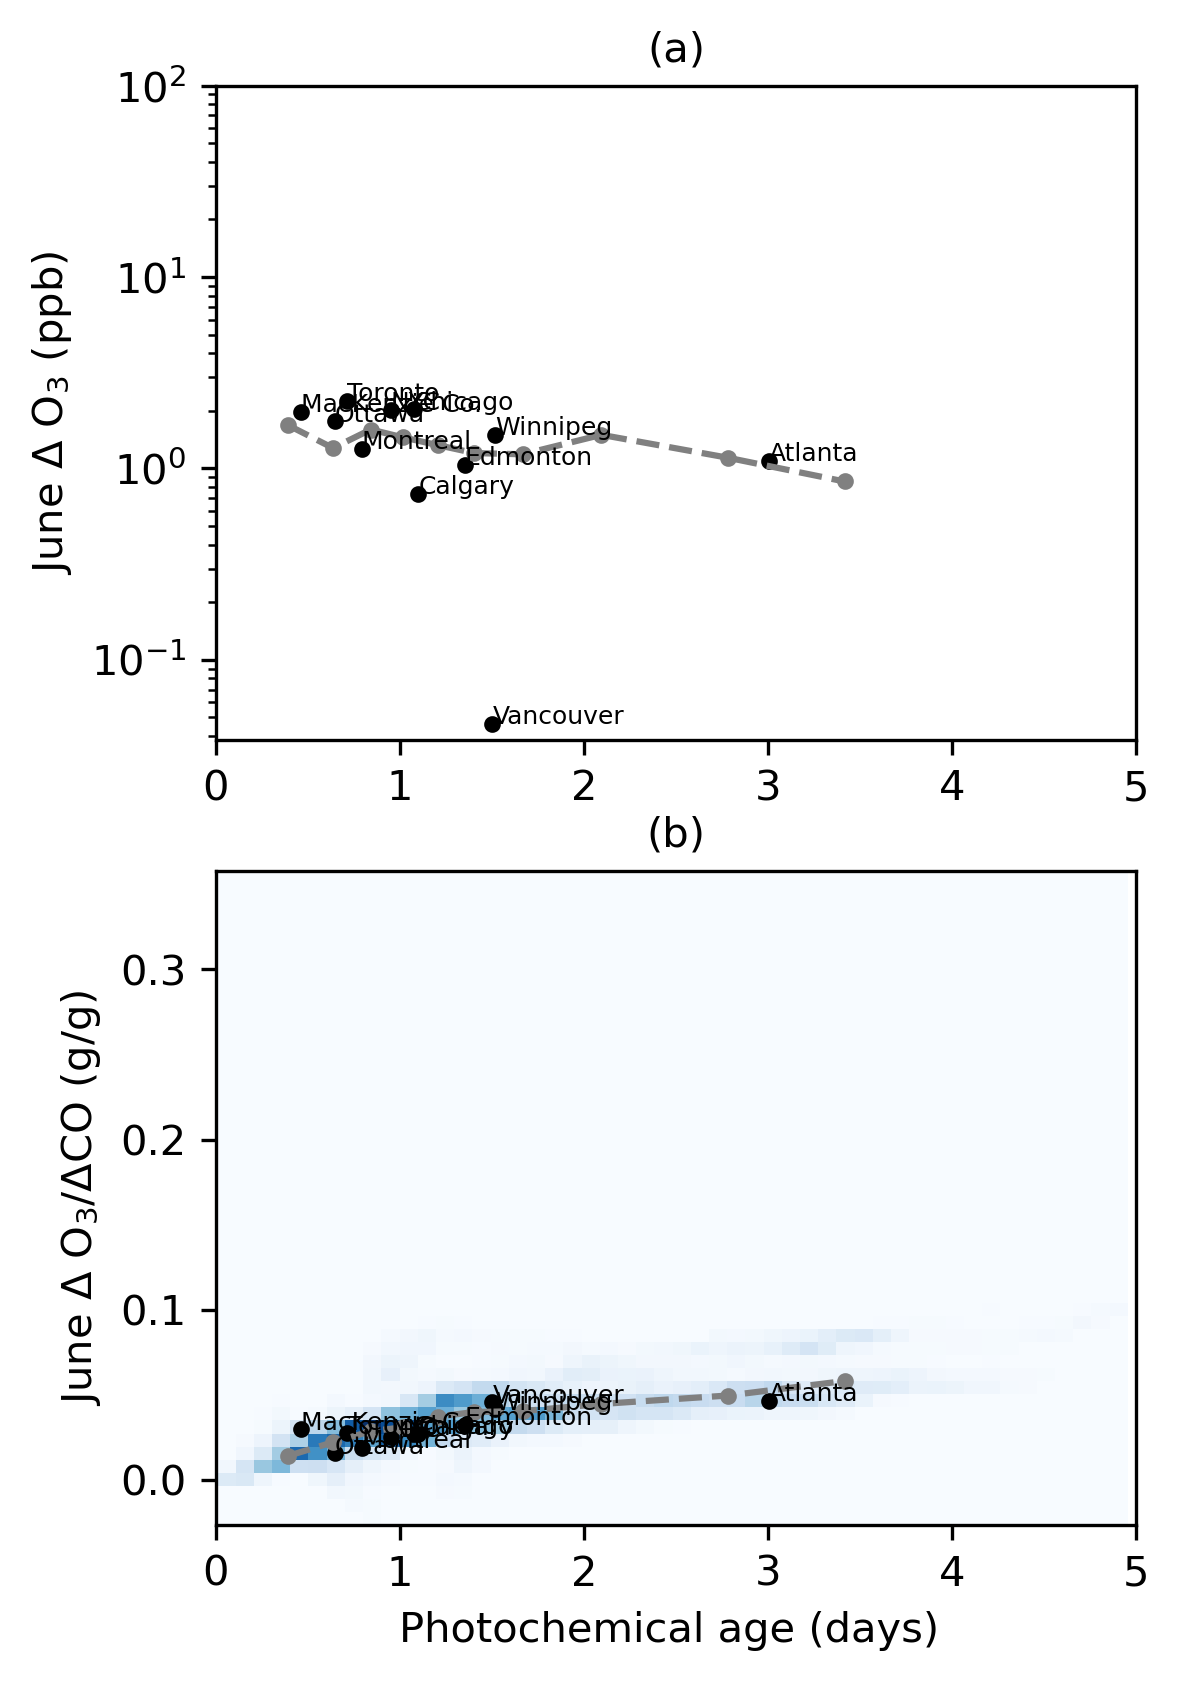

In [26]:
panelfontsize = 10
fig, rax = plt.subplots(
    2, 1, figsize=(3.3, 9.9*2/3), gridspec_kw=dict(
        wspace=0.35, left=0.06, right=0.99, top=0.95, bottom=0.223
    ), dpi=300
)

# Panel 0: O3 vs age
ax = rax[0]
#using_hist2d(ax, dfplot['time'], np.log(dfplot['o3_ppb']))  # Optional: uncomment for density background
ax.plot(dfbin['time'], dfbin['o3_ppb'], '--', color='grey')
ax.plot(dfbin['time'], dfbin['o3_ppb'], '.', color='grey')
ax.set(xlabel=' ', ylabel='June $\\Delta$ O$_3$ (ppb)', yscale='log')
ax.xaxis.set_tick_params(labelsize=panelfontsize)
ax.yaxis.set_tick_params(labelsize=panelfontsize)
ax.xaxis.label.set_size(panelfontsize)
ax.yaxis.label.set_size(panelfontsize)

# Add city markers
for index, row in sites.iterrows():
    lonin = row['lon']
    latin = row['lat']
    i, j = grid.ll2ij(lonin, latin)
    yval = np.array((o3_ppb.squeeze())[j, i].squeeze().data, ndmin=1)[0]
    xval = np.array(bentoltime[:, j, i].squeeze().data, ndmin=1)[0]
    print(row['site'] + ' ' + str(xval) + ' ' + str(yval) + ' ' + row['site'][0:2])
    ax.text(xval, yval, row['site'], fontsize=6)
    ax.scatter(xval, yval, marker='.', color='black')

ax.set_title('(a)')
ax.set_xlim(0, 5)
ax.set_ylim(0, 100)

# Panel 1: O3/CO vs age
ax = rax[1]
using_hist2d(ax, dfplot['time'], dfplot['o3co_gg'])  # 2D histogram background
ax.plot(dfbin['time'], dfbin['o3co_gg'], '--', color='grey')
ax.plot(dfbin['time'], dfbin['o3co_gg'], '.', color='grey')
ax.set(xlabel='Photochemical age (days) ', ylabel='June $\\Delta$ O$_3$/$\\Delta$CO (g/g)')
ax.xaxis.set_tick_params(labelsize=panelfontsize)
ax.yaxis.set_tick_params(labelsize=panelfontsize)
ax.xaxis.label.set_size(panelfontsize)
ax.yaxis.label.set_size(panelfontsize)

# Add city markers
for index, row in sites.iterrows():
    lonin = row['lon']
    latin = row['lat']
    i, j = grid.ll2ij(lonin, latin)
    yval = np.array((o3_ugm3.squeeze() / co_ugm3.squeeze())[j, i].data, ndmin=1)[0]
    xval = np.array(bentoltime[:, j, i].squeeze().data, ndmin=1)[0]
    print(row['site'] + ' ' + str(xval) + ' ' + str(yval) + ' ' + row['site'][0:2])
    ax.text(xval, yval, row['site'], fontsize=6)
    ax.scatter(xval, yval, marker='.', color='black')

ax.set_title('(b)')
ax.set_xlim(0, 5)

plt.savefig(f'{outdir}/{today}_O3_vs_age.png', dpi=300, bbox_inches='tight')
plt.show()

**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consis

NYC 0.95158994 2.0163574 NY
Chicago 1.0777879 2.0357323 Ch
Toronto 0.71331304 2.260891 To
Montreal 0.7944435 1.2691269 Mo
Vancouver 1.5036621 0.046316147 Va
Calgary 1.1002543 0.7368202 Ca
Ottawa 0.6478576 1.7619324 Ot
Edmonton 1.3536474 1.0451717 Ed
MacKenzie Co. 0.46551284 1.9801579 Ma
Winnipeg 1.5178015 1.498064 Wi
Atlanta 3.0071683 1.0965233 At
NYC 0.95158994 0.025259603 NY
Chicago 1.0777879 0.02738238 Ch
Toronto 0.71331304 0.027565358 To
Montreal 0.7944435 0.018842215 Mo
Vancouver 1.5036621 0.045717966 Va
Calgary 1.1002543 0.026985288 Ca
Ottawa 0.6478576 0.015777305 Ot
Edmonton 1.3536474 0.032582223 Ed
MacKenzie Co. 0.46551284 0.029789006 Ma
Winnipeg 1.5178015 0.041586597 Wi
Atlanta 3.0071683 0.04670019 At


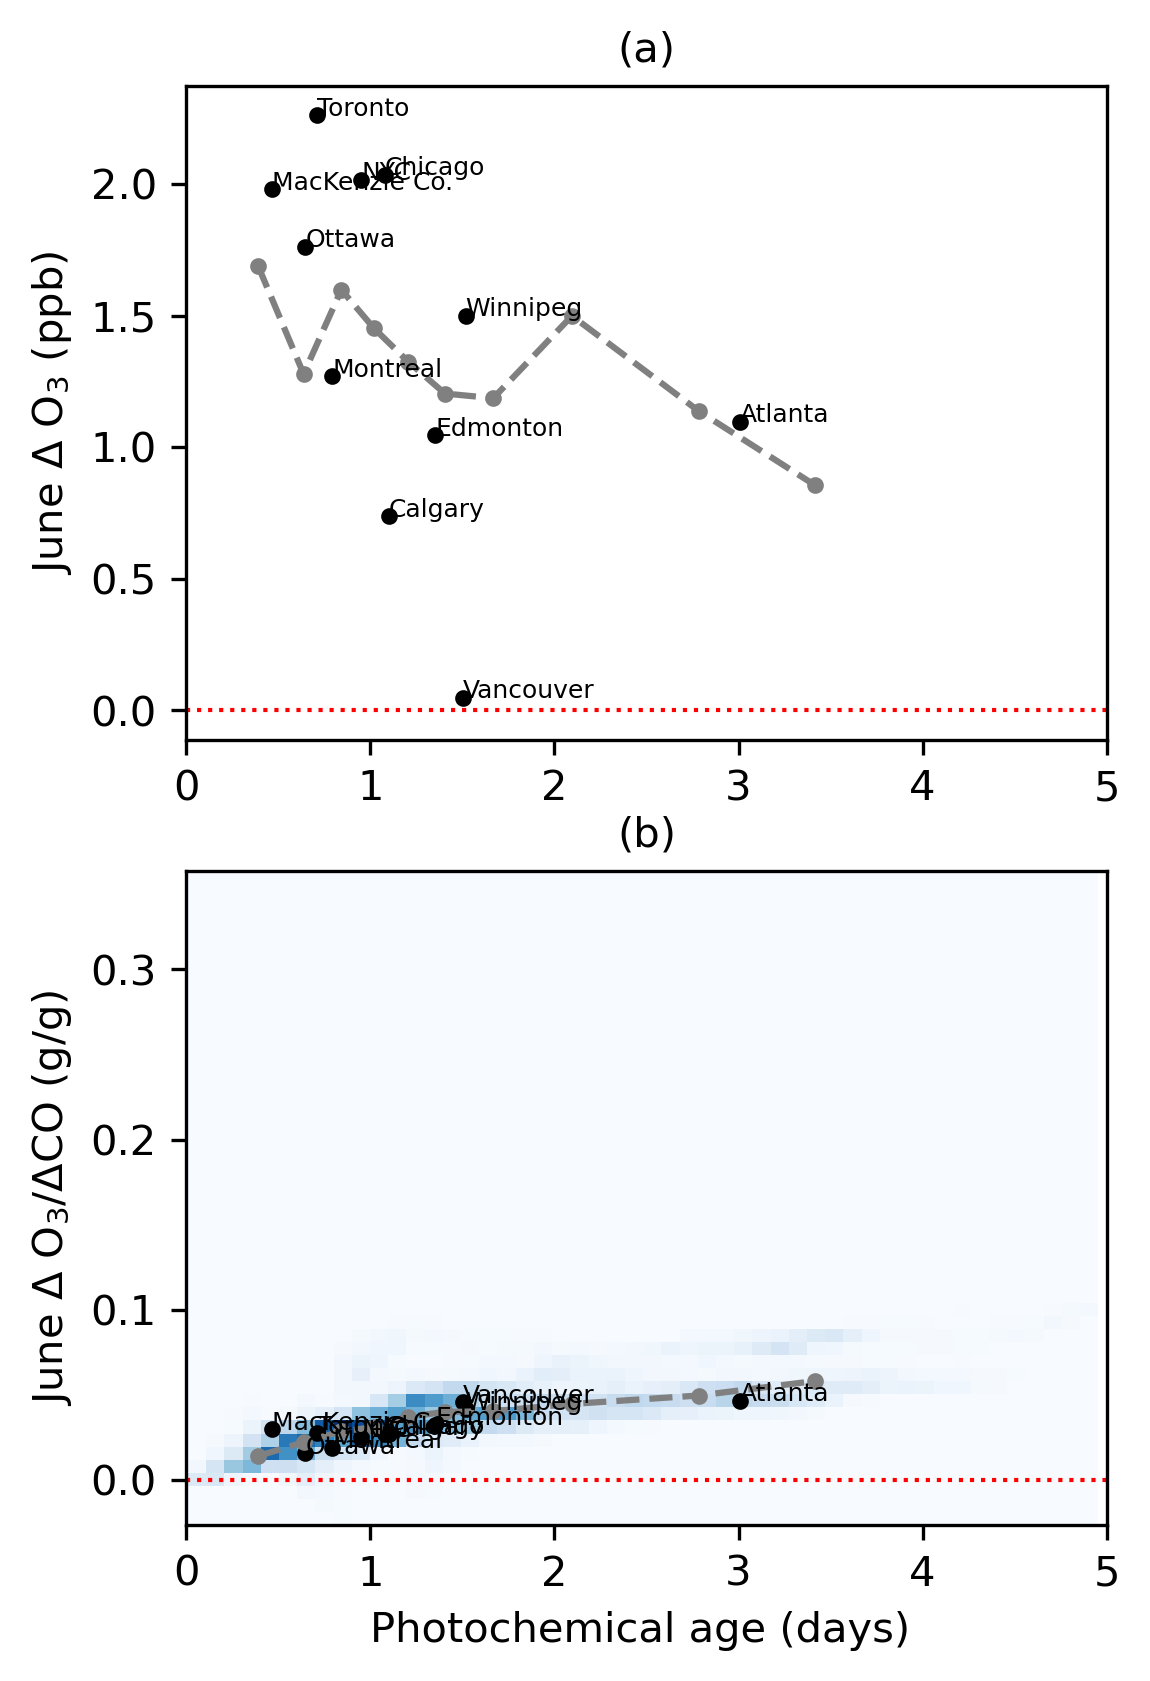

In [22]:
panelfontsize = 10
fig, rax = plt.subplots(
    2, 1, figsize=(3.3, 9.9*2/3), gridspec_kw=dict(
        wspace=0.35, left=0.06, right=0.99, top=0.95, bottom=0.223
    ), dpi=300
)

# Panel 0: O3 vs age (ppb) - GREY STYLE (matching PM2.5)
ax = rax[0]
#using_hist2d(ax, dfplot['time'], dfplot['o3_ppb'])  # Optional: uncomment for density background
ax.plot(dfbin['time'], dfbin['o3_ppb'], '--', color='grey')
ax.plot(dfbin['time'], dfbin['o3_ppb'], '.', color='grey')
ax.set(xlabel=' ', ylabel='June $\\Delta$ O$_3$ (ppb)')
ax.axhline(y=0, color='red', linestyle=':', linewidth=1)  # Zero line
ax.xaxis.set_tick_params(labelsize=panelfontsize)
ax.yaxis.set_tick_params(labelsize=panelfontsize)
ax.xaxis.label.set_size(panelfontsize)
ax.yaxis.label.set_size(panelfontsize)

# Add city markers
for index, row in sites.iterrows():
    lonin = row['lon']
    latin = row['lat']
    i, j = grid.ll2ij(lonin, latin)
    yval = np.array((o3_ppb.squeeze())[j, i].squeeze().data, ndmin=1)[0]
    xval = np.array(bentoltime[:, j, i].squeeze().data, ndmin=1)[0]
    print(row['site'] + ' ' + str(xval) + ' ' + str(yval) + ' ' + row['site'][0:2])
    ax.text(xval, yval, row['site'], fontsize=6)
    ax.scatter(xval, yval, marker='.', color='black')

ax.set_title('(a)')
ax.set_xlim(0, 5)

# Panel 1: O3/CO vs age (g/g mass ratio) - GREY STYLE (matching PM2.5)
ax = rax[1]
using_hist2d(ax, dfplot['time'], dfplot['o3co_gg'])  # 2D histogram background
ax.plot(dfbin['time'], dfbin['o3co_gg'], '--', color='grey')
ax.plot(dfbin['time'], dfbin['o3co_gg'], '.', color='grey')
ax.set(xlabel='Photochemical age (days) ', ylabel='June $\\Delta$ O$_3$/$\\Delta$CO (g/g)')
ax.axhline(y=0, color='red', linestyle=':', linewidth=1)  # Zero line
ax.xaxis.set_tick_params(labelsize=panelfontsize)
ax.yaxis.set_tick_params(labelsize=panelfontsize)
ax.xaxis.label.set_size(panelfontsize)
ax.yaxis.label.set_size(panelfontsize)

# Add city markers
for index, row in sites.iterrows():
    lonin = row['lon']
    latin = row['lat']
    i, j = grid.ll2ij(lonin, latin)
    yval = np.array((o3_ugm3.squeeze() / co_ugm3.squeeze())[j, i].data, ndmin=1)[0]
    xval = np.array(bentoltime[:, j, i].squeeze().data, ndmin=1)[0]
    print(row['site'] + ' ' + str(xval) + ' ' + str(yval) + ' ' + row['site'][0:2])
    ax.text(xval, yval, row['site'], fontsize=6)
    ax.scatter(xval, yval, marker='.', color='black')

ax.set_title('(b)')
ax.set_xlim(0, 5)

plt.savefig(f'{outdir}/{today}_O3_vs_age.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
print(f"O3 ppb range: {dfplot['o3_ppb'].min():.2f} to {dfplot['o3_ppb'].max():.2f}")
print(f"O3/CO range: {dfplot['o3co_gg'].min():.4f} to {dfplot['o3co_gg'].max():.4f}")

O3 ppb range: -0.91 to 5.17
O3/CO range: -0.0264 to 0.3579


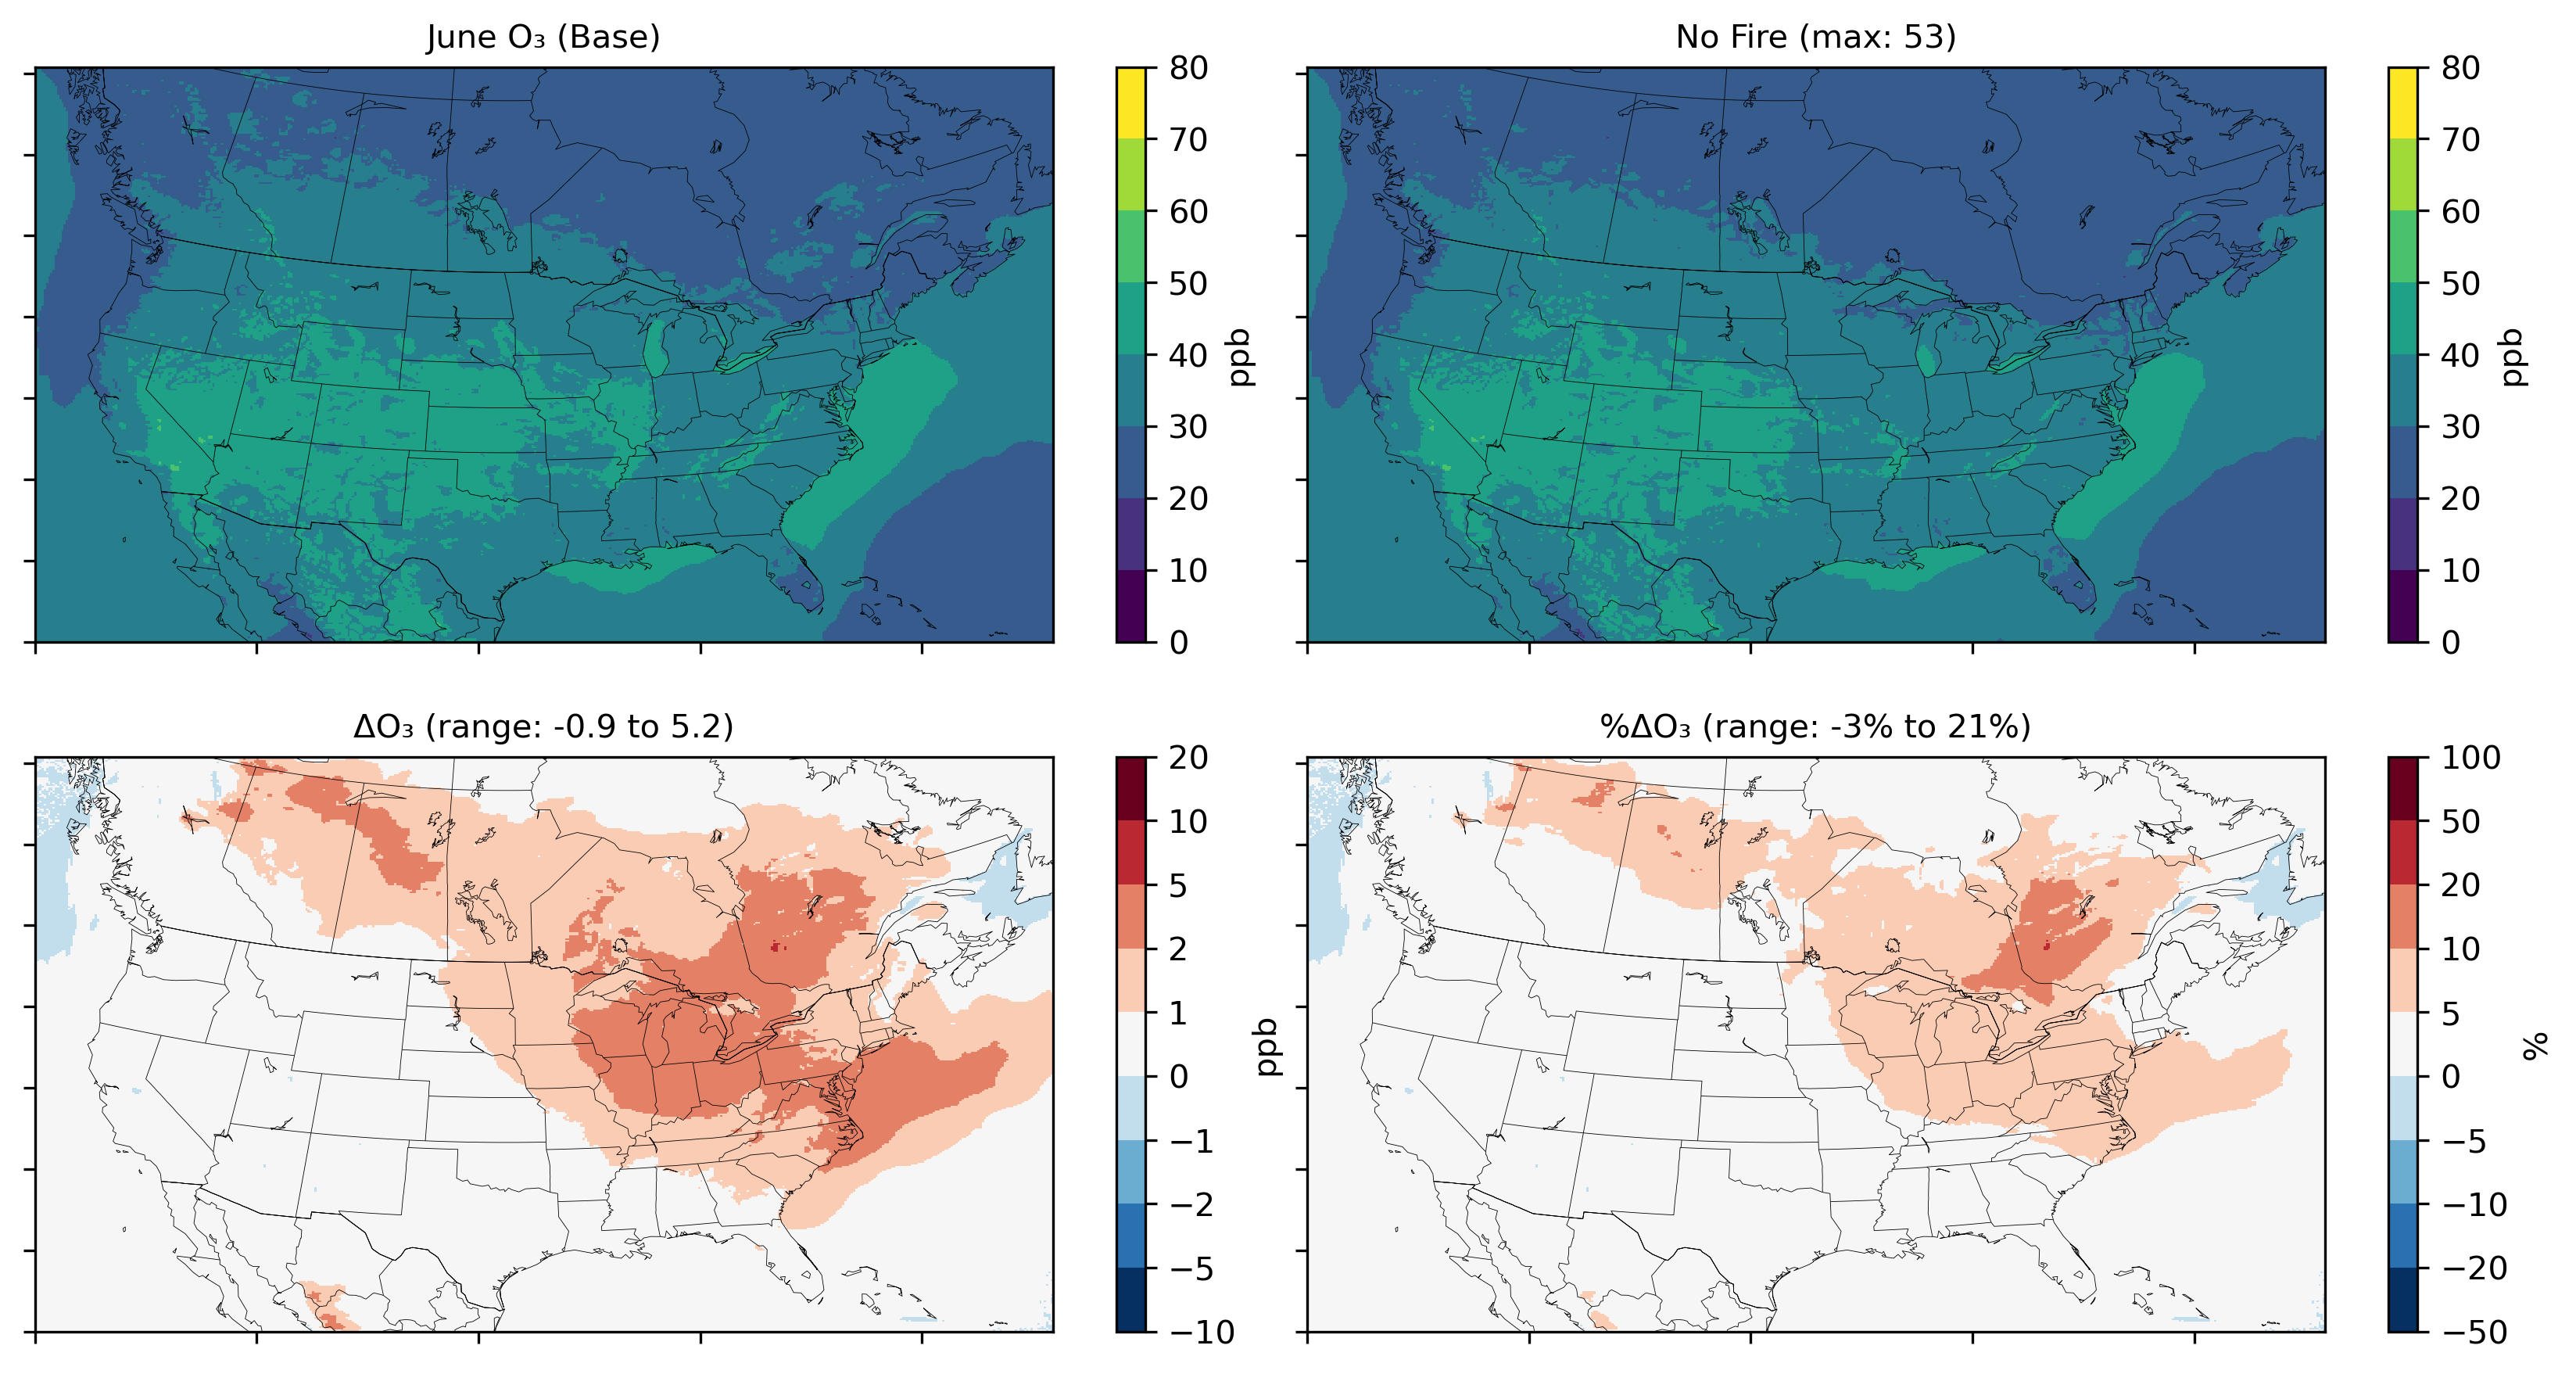

In [34]:
# Four-panel view for ozone (2x2 layout)
spc = 'O3'
units = 'ppb'

plt.rcParams['figure.figsize'] = [14, 7]  # Adjusted for 2x2 layout
fig, axes = plt.subplots(2, 2, dpi=300)
plt.subplots_adjust(wspace=0.0, hspace=0.2)  # Added hspace for vertical spacing

# Panel 0: Base simulation (top-left)
conc = baseconc[spc].mean(dim='TSTEP')
plt.sca(axes[0, 0])
pv = conc.plot(cmap='viridis', levels=[0, 10, 20, 30, 40, 50, 60, 70, 80])
set_map(pv, 'June O₃ (Base)', units)

# Panel 1: No-fire simulation (top-right)
conc = nofireconc[spc].mean(dim='TSTEP')
plt.sca(axes[0, 1])
pv = conc.plot(cmap='viridis', levels=[0, 10, 20, 30, 40, 50, 60, 70, 80])
set_map(pv, f'No Fire (max: {conc.max().values:.0f})', units)

# Panel 2: Delta (bottom-left)
conc = baseconc[spc].mean(dim='TSTEP') - nofireconc[spc].mean(dim='TSTEP')
plt.sca(axes[1, 0])
pv = conc.plot(cmap='RdBu_r', levels=[-10, -5, -2, -1, 0, 1, 2, 5, 10, 20])
set_map(pv, f'ΔO₃ (range: {conc.min().values:.1f} to {conc.max().values:.1f})', units)

# Panel 3: Delta (percent) (bottom-right)
conc = ((baseconc[spc].mean(dim='TSTEP') - nofireconc[spc].mean(dim='TSTEP')) / 
        nofireconc[spc].mean(dim='TSTEP') * 100)
plt.sca(axes[1, 1])
pv = conc.plot(cmap='RdBu_r', levels=[-50, -20, -10, -5, 0, 5, 10, 20, 50, 100])
set_map(pv, f'%ΔO₃ (range: {conc.min().values:.0f}% to {conc.max().values:.0f}%)', '%')

plt.show()

## O3 vs Photochemical Age - NEW ANALYSIS

In [23]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with 2x2 subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('(a) PM<sub>2.5</sub> vs Age', 
                    '(b) O<sub>3</sub> vs Age',
                    '(c) PM<sub>2.5</sub>/CO vs Age', 
                    '(d) O<sub>3</sub>/CO vs Age'),
    vertical_spacing=0.12,
    horizontal_spacing=0.10
)

# Prepare city data
city_data = []
for index, row in sites.iterrows():
    lonin = row['lon']
    latin = row['lat']
    i, j = grid.ll2ij(lonin, latin)
    
    pm25_val = np.array((pm25_ugm3.squeeze())[j, i].squeeze().data, ndmin=1)[0]
    pm25co_val = np.array((pm25_ugm3.squeeze() / co_ugm3.squeeze())[j, i].data, ndmin=1)[0]
    o3_val = np.array((o3_ppb.squeeze())[j, i].squeeze().data, ndmin=1)[0]
    o3co_val = np.array((o3_ugm3.squeeze() / co_ugm3.squeeze())[j, i].data, ndmin=1)[0]
    age_val = np.array(bentoltime[:, j, i].squeeze().data, ndmin=1)[0]
    
    city_data.append({
        'site': row['site'],
        'age': age_val,
        'pm25': pm25_val,
        'pm25co': pm25co_val,
        'o3': o3_val,
        'o3co': o3co_val
    })

# Panel (a): PM2.5 vs Age
fig.add_trace(
    go.Scatter(
        x=dfbin['time'], 
        y=dfbin['pm25'],
        mode='lines+markers',
        name='PM<sub>2.5</sub> Median',
        line=dict(color='purple', dash='dash', width=2),
        marker=dict(size=6, color='purple'),
        legendgroup='pm25',
        showlegend=True,
        hovertemplate='Age: %{x:.2f} days<br>PM<sub>2.5</sub>: %{y:.2f} μg/m³<extra></extra>'
    ),
    row=1, col=1
)

# Add cities for PM2.5
for city in city_data:
    fig.add_trace(
        go.Scatter(
            x=[city['age']], 
            y=[city['pm25']],
            mode='markers+text',
            name=city['site'],
            text=[city['site']],
            textposition='top center',
            textfont=dict(size=8),
            marker=dict(size=8, color='blue'),
            legendgroup='cities',
            showlegend=False,
            hovertemplate=f"{city['site']}<br>Age: {city['age']:.2f} days<br>PM<sub>2.5</sub>: {city['pm25']:.2f} μg/m³<extra></extra>"
        ),
        row=1, col=1
    )

# Panel (b): O3 vs Age
fig.add_trace(
    go.Scatter(
        x=dfbin['time'], 
        y=dfbin['o3_ppb'],
        mode='lines+markers',
        name='O<sub>3</sub> Median',
        line=dict(color='orange', dash='dash', width=2),
        marker=dict(size=6, color='orange'),
        legendgroup='o3',
        showlegend=True,
        hovertemplate='Age: %{x:.2f} days<br>O<sub>3</sub>: %{y:.2f} ppb<extra></extra>'
    ),
    row=1, col=2
)

# Add zero line for O3
fig.add_hline(y=0, line_dash="dot", line_color="red", line_width=1, row=1, col=2)

# Add cities for O3
for city in city_data:
    fig.add_trace(
        go.Scatter(
            x=[city['age']], 
            y=[city['o3']],
            mode='markers+text',
            name=city['site'],
            text=[city['site']],
            textposition='top center',
            textfont=dict(size=8),
            marker=dict(size=8, color='blue'),
            legendgroup='cities',
            showlegend=False,
            hovertemplate=f"{city['site']}<br>Age: {city['age']:.2f} days<br>O<sub>3</sub>: {city['o3']:.2f} ppb<extra></extra>"
        ),
        row=1, col=2
    )

# Panel (c): PM2.5/CO vs Age
fig.add_trace(
    go.Scatter(
        x=dfbin['time'], 
        y=dfbin['pmco_gg'],
        mode='lines+markers',
        name='PM<sub>2.5</sub>/CO Median',
        line=dict(color='purple', dash='dash', width=2),
        marker=dict(size=6, color='purple'),
        legendgroup='pm25co',
        showlegend=True,
        hovertemplate='Age: %{x:.2f} days<br>PM<sub>2.5</sub>/CO: %{y:.4f} g/g<extra></extra>'
    ),
    row=2, col=1
)

# Add cities for PM2.5/CO
for city in city_data:
    fig.add_trace(
        go.Scatter(
            x=[city['age']], 
            y=[city['pm25co']],
            mode='markers+text',
            name=city['site'],
            text=[city['site']],
            textposition='top center',
            textfont=dict(size=8),
            marker=dict(size=8, color='blue'),
            legendgroup='cities',
            showlegend=True if city == city_data[0] else False,
            hovertemplate=f"{city['site']}<br>Age: {city['age']:.2f} days<br>PM<sub>2.5</sub>/CO: {city['pm25co']:.4f} g/g<extra></extra>"
        ),
        row=2, col=1
    )

# Panel (d): O3/CO vs Age
fig.add_trace(
    go.Scatter(
        x=dfbin['time'], 
        y=dfbin['o3co_gg'],
        mode='lines+markers',
        name='O<sub>3</sub>/CO Median',
        line=dict(color='orange', dash='dash', width=2),
        marker=dict(size=6, color='orange'),
        legendgroup='o3co',
        showlegend=True,
        hovertemplate='Age: %{x:.2f} days<br>O<sub>3</sub>/CO: %{y:.4f} g/g<extra></extra>'
    ),
    row=2, col=2
)

# Add zero line for O3/CO
fig.add_hline(y=0, line_dash="dot", line_color="red", line_width=1, row=2, col=2)

# Add cities for O3/CO
for city in city_data:
    fig.add_trace(
        go.Scatter(
            x=[city['age']], 
            y=[city['o3co']],
            mode='markers+text',
            name=city['site'],
            text=[city['site']],
            textposition='top center',
            textfont=dict(size=8),
            marker=dict(size=8, color='blue'),
            legendgroup='cities',
            showlegend=False,
            hovertemplate=f"{city['site']}<br>Age: {city['age']:.2f} days<br>O<sub>3</sub>/CO: {city['o3co']:.4f} g/g<extra></extra>"
        ),
        row=2, col=2
    )

# Update axes
fig.update_xaxes(title_text="Photochemical age (days)", row=2, col=1)
fig.update_xaxes(title_text="Photochemical age (days)", row=2, col=2)
fig.update_xaxes(title_text="", row=1, col=1)
fig.update_xaxes(title_text="", row=1, col=2)

fig.update_yaxes(title_text="June ΔPM<sub>2.5</sub> (μg/m³)", type="log", row=1, col=1)
fig.update_yaxes(title_text="June ΔO<sub>3</sub> (ppb)", row=1, col=2)
fig.update_yaxes(title_text="June ΔPM<sub>2.5</sub>/ΔCO (g/g)", row=2, col=1)
fig.update_yaxes(title_text="June ΔO<sub>3</sub>/ΔCO (g/g)", row=2, col=2)

# Set x-axis limits
fig.update_xaxes(range=[0, 5], row=1, col=1)
fig.update_xaxes(range=[0, 5], row=1, col=2)
fig.update_xaxes(range=[0, 5], row=2, col=1)
fig.update_xaxes(range=[0, 5], row=2, col=2)

# Update layout
fig.update_layout(
    title_text="Wildfire Smoke Evolution - INTERACTIVE<br><sub>Hover over points to see city names</sub>",
    title_x=0.5,
    height=800,
    width=1000,
    showlegend=True,
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02,
        title="Legend<br><i>Click to toggle</i>"
    ),
    hovermode='closest',
    # Enable zoom and reset
    dragmode='zoom',  # Select to zoom
    # Double-click to reset is enabled by default in Plotly
)

# Add annotation for instructions
fig.add_annotation(
    text="<i>📌 Drag to zoom | Double-click to reset</i>",
    xref="paper", yref="paper",
    x=0.5, y=-0.08,
    showarrow=False,
    font=dict(size=10, color="gray")
)

# Show the figure
fig.show()

# Optionally save as HTML
html_file = f'{outdir}/{today}_interactive_smoke_evolution.html'
fig.write_html(html_file)
print(f'Saved interactive plot to: {html_file}')

**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consis

Saved interactive plot to: D:/Raw_Data/CMAQ_Model/outputs//20251118_interactive_smoke_evolution.html


**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF
**PNC:c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\PseudoNetCDF\pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consis

NYC 0.95158994 2.0163574 NY
Chicago 1.0777879 2.0357323 Ch
Toronto 0.71331304 2.260891 To
Montreal 0.7944435 1.2691269 Mo
Vancouver 1.5036621 0.046316147 Va
Calgary 1.1002543 0.7368202 Ca
Ottawa 0.6478576 1.7619324 Ot
Edmonton 1.3536474 1.0451717 Ed
MacKenzie Co. 0.46551284 1.9801579 Ma
Winnipeg 1.5178015 1.498064 Wi
Atlanta 3.0071683 1.0965233 At
NYC 0.95158994 0.025259603 NY
Chicago 1.0777879 0.02738238 Ch
Toronto 0.71331304 0.027565358 To
Montreal 0.7944435 0.018842215 Mo
Vancouver 1.5036621 0.045717966 Va
Calgary 1.1002543 0.026985288 Ca
Ottawa 0.6478576 0.015777305 Ot
Edmonton 1.3536474 0.032582223 Ed
MacKenzie Co. 0.46551284 0.029789006 Ma
Winnipeg 1.5178015 0.041586597 Wi
Atlanta 3.0071683 0.04670019 At


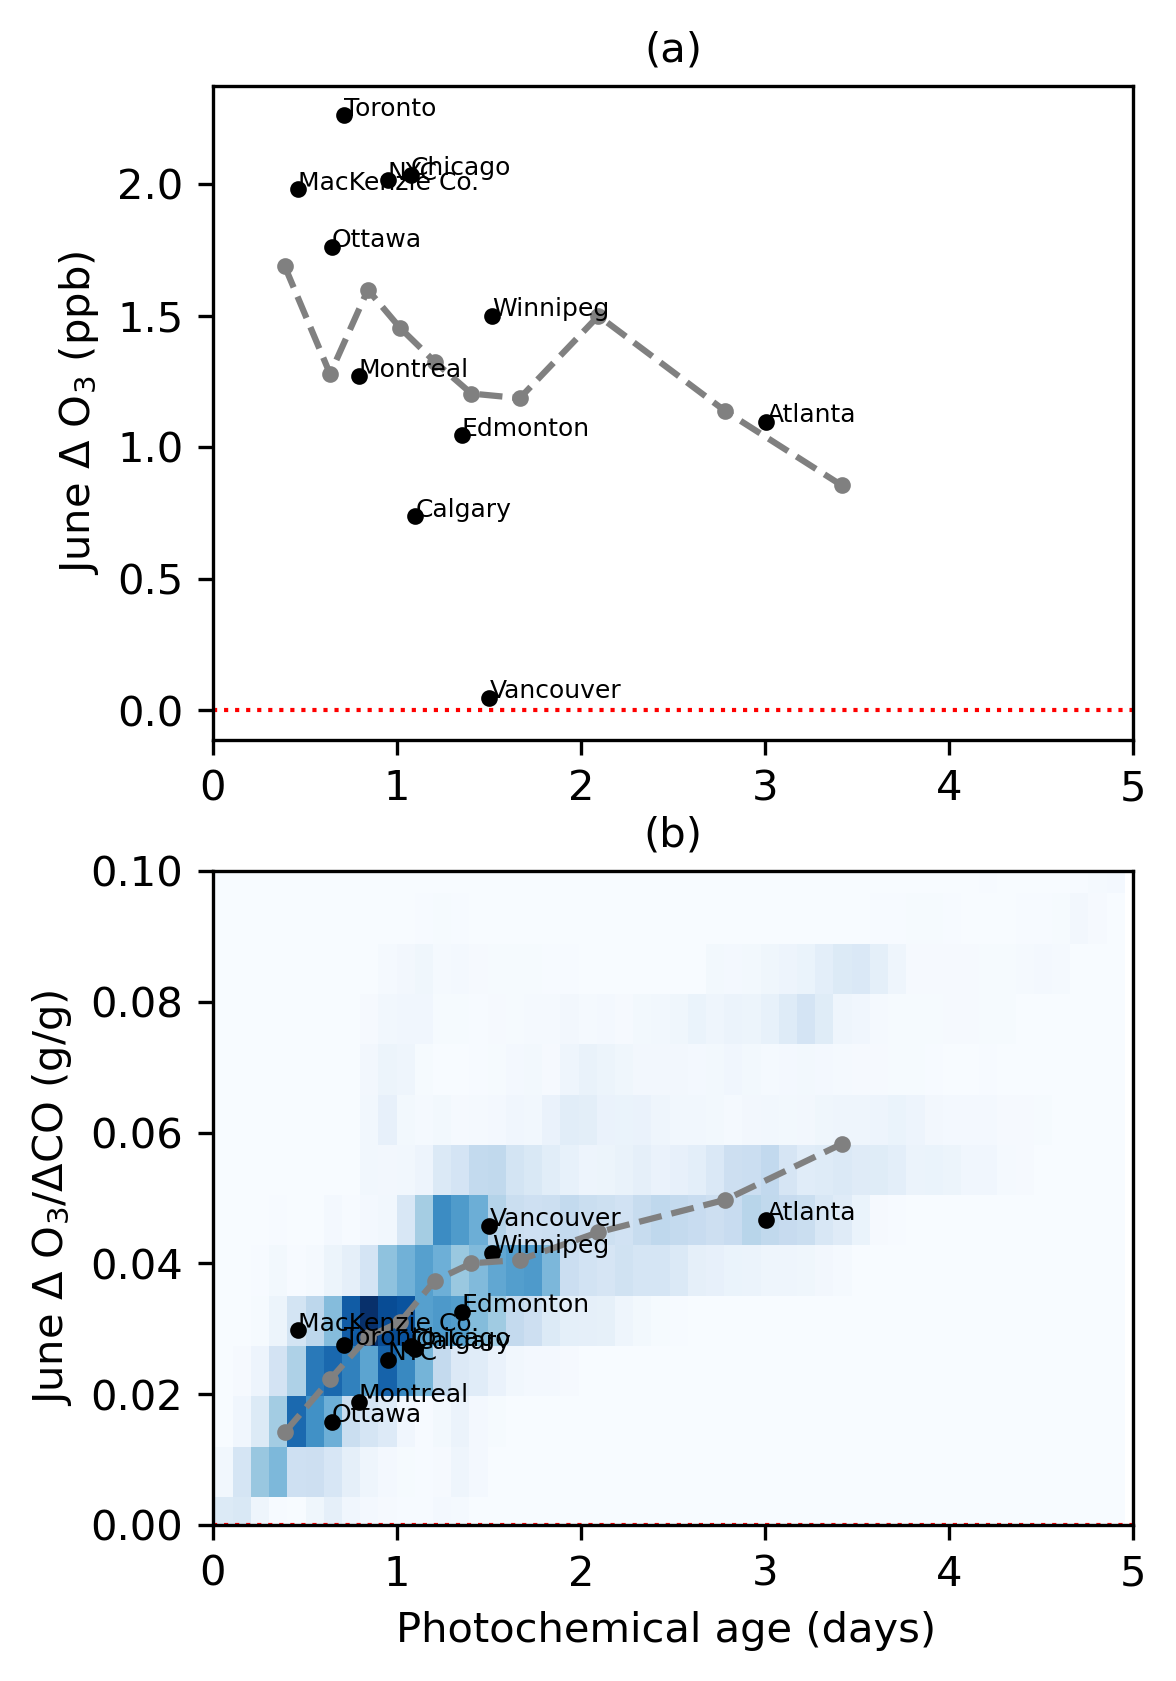

In [30]:
panelfontsize = 10
fig, rax = plt.subplots(
    2, 1, figsize=(3.3, 9.9*2/3), gridspec_kw=dict(
        wspace=0.35, left=0.06, right=0.99, top=0.95, bottom=0.223
    ), dpi=300
)

# Panel 0: O3 vs age (ppb) - LINEAR SCALE
ax = rax[0]
#using_hist2d(ax, dfplot['time'], dfplot['o3_ppb'])  # Optional: uncomment for density background
ax.plot(dfbin['time'], dfbin['o3_ppb'], '--', color='grey')
ax.plot(dfbin['time'], dfbin['o3_ppb'], '.', color='grey')
ax.axhline(y=0, color='red', linestyle=':', linewidth=1)  # Zero line - scientifically meaningful!
ax.set(xlabel=' ', ylabel='June $\\Delta$ O$_3$ (ppb)')
ax.xaxis.set_tick_params(labelsize=panelfontsize)
ax.yaxis.set_tick_params(labelsize=panelfontsize)
ax.xaxis.label.set_size(panelfontsize)
ax.yaxis.label.set_size(panelfontsize)

# Add city markers
for index, row in sites.iterrows():
    lonin = row['lon']
    latin = row['lat']
    i, j = grid.ll2ij(lonin, latin)
    yval = np.array((o3_ppb.squeeze())[j, i].squeeze().data, ndmin=1)[0]
    xval = np.array(bentoltime[:, j, i].squeeze().data, ndmin=1)[0]
    print(row['site'] + ' ' + str(xval) + ' ' + str(yval) + ' ' + row['site'][0:2])
    ax.text(xval, yval, row['site'], fontsize=6)
    ax.scatter(xval, yval, marker='.', color='black')

ax.set_title('(a)')
ax.set_xlim(0, 5)
# ax.set_ylim(-2, 6)  # Optional: adjust based on your data

# Panel 1: O3/CO vs age (g/g)
ax = rax[1]
using_hist2d(ax, dfplot['time'], dfplot['o3co_gg'])  # 2D histogram background
ax.plot(dfbin['time'], dfbin['o3co_gg'], '--', color='grey')
ax.plot(dfbin['time'], dfbin['o3co_gg'], '.', color='grey')
ax.axhline(y=0, color='red', linestyle=':', linewidth=1)  # Zero line
ax.set(xlabel='Photochemical age (days) ', ylabel='June $\\Delta$ O$_3$/$\\Delta$CO (g/g)')
ax.xaxis.set_tick_params(labelsize=panelfontsize)
ax.yaxis.set_tick_params(labelsize=panelfontsize)
ax.xaxis.label.set_size(panelfontsize)
ax.yaxis.label.set_size(panelfontsize)

# Add city markers
for index, row in sites.iterrows():
    lonin = row['lon']
    latin = row['lat']
    i, j = grid.ll2ij(lonin, latin)
    yval = np.array((o3_ugm3.squeeze() / co_ugm3.squeeze())[j, i].data, ndmin=1)[0]
    xval = np.array(bentoltime[:, j, i].squeeze().data, ndmin=1)[0]
    print(row['site'] + ' ' + str(xval) + ' ' + str(yval) + ' ' + row['site'][0:2])
    ax.text(xval, yval, row['site'], fontsize=6)
    ax.scatter(xval, yval, marker='.', color='black')

ax.set_title('(b)')
ax.set_xlim(0, 5)
ax.set_ylim(0, .1)  

plt.savefig(f'{outdir}/{today}_O3_vs_age.png', dpi=300, bbox_inches='tight')
plt.show()

## Interactive Plot - Wildfire Smoke Evolution

## Summary Statistics

In [24]:
print('=== SUMMARY STATISTICS ===')
print('\\nPM2.5 Fire Impact:')
print(f'  Mean: {pm25_ugm3.mean().values:.2f} μg/m³')
print(f'  Max:  {pm25_ugm3.max().values:.2f} μg/m³')
print(f'  Min:  {pm25_ugm3.min().values:.2f} μg/m³')

print('\\nO3 Fire Impact:')
print(f'  Mean: {o3_ppb.mean().values:.2f} ppb  ({o3_ugm3.mean().values:.2f} μg/m³)')
print(f'  Max:  {o3_ppb.max().values:.2f} ppb  ({o3_ugm3.max().values:.2f} μg/m³)')
print(f'  Min:  {o3_ppb.min().values:.2f} ppb  ({o3_ugm3.min().values:.2f} μg/m³)')

print('\\nCO Fire Impact:')
print(f'  Mean: {co_ppb.mean().values:.2f} ppb  ({co_ugm3.mean().values:.2f} μg/m³)')
print(f'  Max:  {co_ppb.max().values:.2f} ppb  ({co_ugm3.max().values:.2f} μg/m³)')

print('\\nPhotochemical Age:')
print(f'  Mean: {bentoltime.mean().values:.2f} days')
print(f'  Max:  {bentoltime.max().values:.2f} days')

print('\\nMass Ratios (smoke-affected regions):')
print(f'  PM2.5/CO (g/g): {dfplot["pmco_gg"].mean():.4f} ± {dfplot["pmco_gg"].std():.4f}')
print(f'  O3/CO (g/g):    {dfplot["o3co_gg"].mean():.4f} ± {dfplot["o3co_gg"].std():.4f}')

=== SUMMARY STATISTICS ===
\nPM2.5 Fire Impact:
  Mean: 5.18 μg/m³
  Max:  898.56 μg/m³
  Min:  -0.00 μg/m³
\nO3 Fire Impact:
  Mean: 0.83 ppb  (1.56 μg/m³)
  Max:  5.17 ppb  (9.83 μg/m³)
  Min:  -0.91 ppb  (-1.58 μg/m³)
\nCO Fire Impact:
  Mean: 49.50 ppb  (54.65 μg/m³)
  Max:  5423.54 ppb  (6093.87 μg/m³)
\nPhotochemical Age:
  Mean: nan days
  Max:  inf days
\nMass Ratios (smoke-affected regions):
  PM2.5/CO (g/g): 0.0832 ± 0.0217
  O3/CO (g/g):    0.0385 ± 0.0194


c:\Users\smtku\miniconda3\envs\cmaq-analysis\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning:

invalid value encountered in reduce



## Export Data to CSV

In [25]:
# Save the smoke-masked data
csv_file = f'{outdir}/{today}_smoke_masked_data.csv'
dfplot.to_csv(csv_file, index=False)
print(f'Saved smoke-masked data to: {csv_file}')

# Save binned data
csv_file_bin = f'{outdir}/{today}_binned_data.csv'
dfbin.to_csv(csv_file_bin)
print(f'Saved binned data to: {csv_file_bin}')

Saved smoke-masked data to: D:/Raw_Data/CMAQ_Model/outputs//20251118_smoke_masked_data.csv
Saved binned data to: D:/Raw_Data/CMAQ_Model/outputs//20251118_binned_data.csv


## Analysis Complete!

This notebook analyzed:
- ✓ PM2.5 fire impacts (concentrations, maps, time series)
- ✓ O3 fire impacts (concentrations, maps, time series) - NEW!
- ✓ Photochemical age from benzene/toluene ratios
- ✓ PM2.5/CO and O3/CO ratios vs age
- ✓ City-specific impacts

All outputs saved to: `D:/Raw_Data/CMAQ_Model/outputs/`